# Recurrent Neural Net (RNN) w/Custom Attention

Before moving on to other architectures, we'll introduce one last concept on RNN's, the concept of __attention__.

One of the main reasons to use attention is the observation that LSTM layers become __less accurate as their length increases__, in NLP applications they loose accuracy when they reach a length of about 20 words and further loose accuracy fairly quickly as their length increases. At around 50 words, performance starts getting fairly poor. Research has show that in NLP applications the performance can be maintained at high levels, beyond a length of 50 words if attention is applied to the series of words.

There are a lot of good resources online that go into details on how self-attention works. We'll cover it in extremely broad terms here. Attention is basically a way for the model to 'pay atttention' to the most relevant parts of the series. There's lots of ways to implement attention. Let's have some fun with a custom 'Fraud' implementation. __It is different to the standard reference__ as described in famed [Attention is all you need paper](https://arxiv.org/abs/1706.03762). We'll use one which is less complex and see how we got on with that.

Our assumption, *(which needs to be validated)*, will be that while looking at a series of transactions some transctions will be less important in assessing the label than others. Up until now we treat all transactions in a series as equal. But we could try and change that, by assining different weights to each transaction in the series.

We will achieve this by coming up with a vector that contains weights with with we can weight our series of payments, the sum of weights for one transaction in the series will be one.

If $T$ is a 2-D Tensor of size (s,f). I.e a __*S*__eries of transactions each having __*F*__eatures. Then our weighted series $wT$ will be $wT_{sf} = T_{sf} * W_{s}$. We just multiply each feature at a position in the series with the weight of that series position.

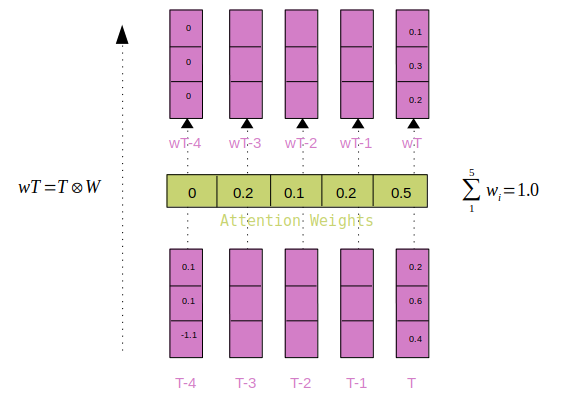

In the example we have 5 transactions. The weights make is so we pay most attention to the last payment, it is multiplied by 0.5. No attention whatsoever is paid to the first payment at T-4, it has 0 as weight.

The million dollar trick is determining the weights; the weights are calculated by taking the dot product of the vector at each time step with the *transpose* of the vector at the last time-step. So $W_{T-i} = T_{T-i} \odot T^T_{T} $.

That will give us raw weights, those raw weights are 'Softmaxed' so they are scaled and add up to one. 

In the attention paper the these vectors are named the __key__ and the __query__. In this implementation the keys are the transactions at each time-step, the query is always the last transactions.

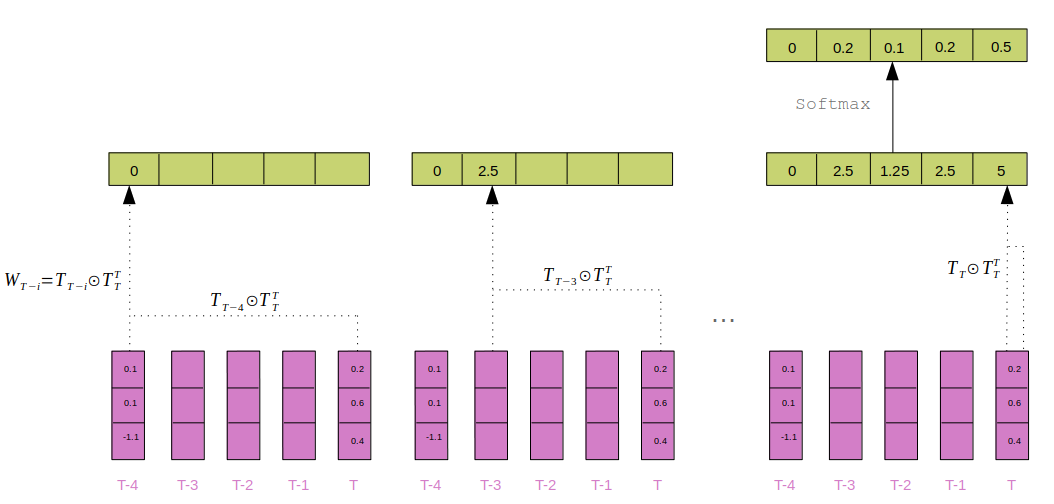

People who are not very familar with machine learning and linear algebra might wonder what the meaning is of $T_{T-i} \odot T^T_{T}$. What does this say about the 2 payments? From a linear algebra perspective, it means the vectors of these payments point more or less in the same direction. The dot product of 2 vectors is a scalar (a single number). It is basically the cosine of their angle multiplied by their lenghts. $T_{x} \odot T_{y}^t = \cos\theta \cdot \lvert T_{x} \rvert \cdot \lvert T_{y} \rvert$.

Because of the cosine element, the more the vectors allign and point in the same general direction the more positive the dot product will tend to be. Two vectors that are perpendicular will have 0 as dot product. Beyond that between 90 and 180 degrees the dot product will be negative. It can thus, a bit handwavy, be seen as a __measure of similarity__.

The more our payments resemble, the higher our raw weights. We can see that we are likely to pay a lot of  attention to the last payment, the transpose dot product of a vector with itself will have a cosine of 1.

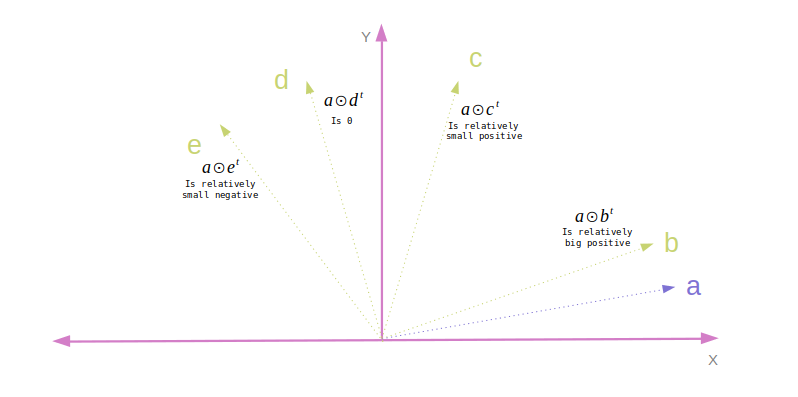

There is one more thing we do, before applying the dot product between __key__ and __query__ we apply learnable parameters to them. That means we allow the model to project the key and the query into a new space. The parameters are learnable, implying that the model does not need to use the raw input but it can learn to 'project/transform' the keys and query into a space so their *similarity measure* can be used to reduce the loss.

---
#### Note on the data set 
The data set used here is not particularly complex and/or big. It's not really all that challenging to find the fraud. In an ideal world we'd be using more complex data sets to show the real power of Deep Learning. There are a bunch of PCA'ed data sets available, but the PCA obfuscates some of the elements that are useful. 
*These examples are meant to show the possibilities, it's not so useful to interpret their performance on this data set*

In [1]:
import torch
import numpy as np
import pandas as pd
import datetime as dt
import gc

import d373c7.features as ft
import d373c7.engines as en
import d373c7.pytorch as pt
import d373c7.pytorch.models as pm
import d373c7.plot as pl

## Set a random seed for Numpy and Torch
> Will make sure we always sample in the same way. Makes it easier to compare results. At some point it should been removed to test the model stability.

In [2]:
# Numpy
np.random.seed(42)
# Torch
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Define base feature and read the File
The base features are features found in the input file. They need to be defined after which the file can be read using the `EnginePandasNumpy`. Using the `from_csv` method.

In [3]:
# Change this to read from another location
file = '../../../../data/bs140513_032310.csv'

In [4]:
step = ft.FeatureSource('step', ft.FEATURE_TYPE_INT_16) 
customer = ft.FeatureSource('customer', ft.FEATURE_TYPE_STRING)
age = ft.FeatureSource('age', ft.FEATURE_TYPE_CATEGORICAL)
gender = ft.FeatureSource('gender', ft.FEATURE_TYPE_CATEGORICAL)
merchant = ft.FeatureSource('merchant', ft.FEATURE_TYPE_CATEGORICAL)
category = ft.FeatureSource('category', ft.FEATURE_TYPE_CATEGORICAL)
amount = ft.FeatureSource('amount', ft.FEATURE_TYPE_FLOAT)
fraud = ft.FeatureSource('fraud', ft.FEATURE_TYPE_INT_8)

base_features = ft.TensorDefinition(
    'base', 
    [
        step,
        customer,
        age,
        gender,
        merchant,
        category,
        amount,
        fraud
    ])

# Function to calculate the date and time from the step
def step_to_date(step_count: int):
    return dt.datetime(2020, 1, 1) + dt.timedelta(days=int(step_count))

# Function to calculate the time difference between all rows and normalise
def calc_delta(dates):
    if isinstance(dates, pd.DataFrame):
        res = dates.diff() / np.timedelta64(190, 'D')
        res = res.fillna(0).abs()
        return res
    else:
        # There was only 1 row
        return 0

date_time = ft.FeatureExpression('date', ft.FEATURE_TYPE_DATE_TIME, step_to_date, [step])
date_time_delta = ft.FeatureExpressionSeries('delta', ft.FEATURE_TYPE_FLOAT_32, calc_delta, [date_time])

intermediate_features = ft.TensorDefinition(
    'intermediate', 
    [
        customer,
        step,
        age,
        gender,
        merchant,
        category,
        amount,
        fraud
    ])

age_i = ft.FeatureIndex('age_index', ft.FEATURE_TYPE_INT_8, age)
gender_i = ft.FeatureIndex('gender_index', ft.FEATURE_TYPE_INT_8, gender)
merchant_i = ft.FeatureIndex('merchant_index', ft.FEATURE_TYPE_INT_16, merchant)
category_i = ft.FeatureIndex('category_index', ft.FEATURE_TYPE_INT_16, category)
amount_scale = ft.FeatureNormalizeScale('amount_scale', ft.FEATURE_TYPE_FLOAT_32, amount)
fraud_label = ft.FeatureLabelBinary('fraud_label', fraud)

cust_learn_features = ft.TensorDefinition(
    'customer_learning', 
    [
        age_i,
        gender_i,
    ])

trx_learn_features = ft.TensorDefinition(
    'transaction_learning', 
    [
        customer,
        date_time,
        merchant_i,
        category_i,
        amount_scale,
        date_time_delta,
        fraud_label
    ])

multi_head_td = ft.TensorDefinitionMulti([cust_learn_features, trx_learn_features])

with en.EnginePandasNumpy(num_threads=8) as e:
    df = e.from_csv(base_features, file, inference=False)
    df = e.from_df(intermediate_features, df, inference=False)
    cust_df = e.from_df(cust_learn_features, df, inference=False)
    trx_df  = e.from_df(trx_learn_features, df, inference=False)
    cust_list = e.to_numpy_list(cust_learn_features, cust_df)
    series_list = e.to_series_stacked(trx_df, trx_learn_features, key_field=customer, time_field=date_time, length=5)

print('Customer data Shapes')
print(cust_list.shapes)
print(cust_list.dtype_names)
print('Series Shapes')
print(series_list.shapes)
print(series_list.dtype_names)

data_list = en.NumpyList(cust_list.lists + series_list.lists)
print('Numpy Shapes')
print(data_list.shapes)    

2020-12-08 10:57:00.603 d373c7.engines.common          INFO     Start Engine...
2020-12-08 10:57:00.603 d373c7.engines.panda_numpy     INFO     Pandas Version : 1.1.4
2020-12-08 10:57:00.604 d373c7.engines.panda_numpy     INFO     Numpy Version : 1.19.2
2020-12-08 10:57:00.604 d373c7.engines.panda_numpy     INFO     Building Panda for : base from file ../../../../data/bs140513_032310.csv
2020-12-08 10:57:00.843 d373c7.engines.panda_numpy     INFO     Building Panda for : <base> from DataFrame. Inference mode <False>
2020-12-08 10:57:00.859 d373c7.engines.panda_numpy     INFO     Done creating base. Shape=(594643, 8)
2020-12-08 10:57:00.860 d373c7.engines.panda_numpy     INFO     Building Panda for : <intermediate> from DataFrame. Inference mode <False>
2020-12-08 10:57:00.872 d373c7.engines.panda_numpy     INFO     Done creating intermediate. Shape=(594643, 8)
2020-12-08 10:57:00.873 d373c7.engines.panda_numpy     INFO     Building Panda for : <customer_learning> from DataFrame. Infere

Customer data Shapes
[(594643, 2)]
['int8']
Series Shapes
[(594643, 5, 2), (594643, 5, 2), (594643, 1)]
['float32', 'int16', 'int8']
Numpy Shapes
[(594643, 2), (594643, 5, 2), (594643, 5, 2), (594643, 1)]


## Wrangle the data
Time to split the data. For time series data it is very important to keep the order of the data. Below split will start from the end and work it's way to the front of the data. Doing so the training, validation and test data are nicely colocated in time. You almost *never* want to plain shuffle time based data.

> 1. Split out a test-set of size `test_records`. This is used for model testing.
> 2. Split out a validation-set of size `validation_records`. It will be used to monitor overfitting during training
> 3. All the rest is considered training data.

For time-series we'll perform an additional action.
> 1. The series at the beginning of the data set will all be more or less empty as there is no history, that is not so useful during training, ideally we have records with history and complete series, sometimes named 'mature' series. We'll throw away the first couple of entries.

__Important__; please make sure the data is ordered in ascending fashion on a date(time) field. The split function does not order the data, it assumes the data is in the correct order.

In [5]:
test_records = 100000
val_records  = 30000 
maturation   = 30000

train_data, val_data, test_data = data_list.split_time(val_records, test_records) 
train_data = train_data[maturation:]

print(f'Training Data shapes {train_data.shapes}')
print(f'Validation Data shapes {val_data.shapes}')
print(f'Test Data shapes {test_data.shapes}')
del data_list
gc.collect()
print('Done')

Training Data shapes [(434643, 2), (434643, 5, 2), (434643, 5, 2), (434643, 1)]
Validation Data shapes [(30000, 2), (30000, 5, 2), (30000, 5, 2), (30000, 1)]
Test Data shapes [(100000, 2), (100000, 5, 2), (100000, 5, 2), (100000, 1)]
Done


## Set-up Devices

In [6]:
device, cpu = pt.init_devices()

2020-12-08 10:57:08.104 d373c7.pytorch.common          INFO     Torch Version : 1.7.0
2020-12-08 10:57:08.154 d373c7.pytorch.common          INFO     GPU found. Using GPU <0>
2020-12-08 10:57:08.155 d373c7.pytorch.common          INFO     Cuda Version  : 10.2


## Build the model

> In this example we use a `ReccurentFraudClassifierMulti` model. We give it the TensorDefinitionMulti of Learning features (containing a TensorDefinition for the Customer featurea and a TensorDefinition for the Transaction Features), then ask it to build a __LSTM__ style RNN, use *16* recurrent features, *1* recurrent layer and add 1 layer of *8* linear features after that.

In [7]:
# Setup Pytorch Datasets for the training and validation
batch_size = 128
train_ds = pt.NumpyListDataSetMulti(multi_head_td, train_data)
val_ds = pt.NumpyListDataSetMulti(multi_head_td, val_data)
train_sampler = pt.ClassSamplerMulti(multi_head_td, train_data).over_sampler()

# Wrap them in a Pytorch Dataloader
train_dl = train_ds.data_loader(cpu, batch_size, num_workers=2, sampler=train_sampler)
val_dl = val_ds.data_loader(cpu, batch_size, num_workers=2)

# Set defaults.
defaults = pm.RecurrentClassifierDefaults()
defaults.set_attention_heads(1)

# Create a Model
m = pm.RecurrentFraudClassifierMulti(
    multi_head_td, 'LSTM', recurrent_features=16, recurrent_layers=1, linear_layers=[8], defaults=defaults
)
print(m)

RecurrentFraudClassifierMulti(
  Number of parameters : 8388
  (head): TensorDefinitionHeadMulti(
    Embedded TDs=['customer_learning', 'transaction_learning']
    (heads): ModuleList(
      (0): TensorDefinitionHead(
        lcs=['Categorical']
        (embedding): Embedding(
          (embeddings): ModuleList(
            (0): Embedding(9, 4)
            (1): Embedding(5, 4)
          )
          (dropout): Dropout(p=0.2, inplace=False)
        )
      )
      (1): TensorDefinitionHead(
        lcs=['Continuous', 'Categorical']
        (embedding): Embedding(
          (embeddings): ModuleList(
            (0): Embedding(51, 25)
            (1): Embedding(16, 7)
          )
          (dropout): Dropout(p=0.2, inplace=False)
        )
      )
    )
  )
  (body): BodyMulti(
    (layers): ModuleList(
      (0): None
      (1): BodySequential(
        (layers): Sequential(
          (seq_00): AttentionLastEntry()
          (seq_01): LSTMBody(
            (rnn): LSTM(32, 16, batch_first=

## Start Training

### First find a decent Learning Rate. 
> Create a trainer and run the find_lr function and plot. This functions iterates over the batches gradually increasing the learning rate from a minimum to a maximum learning rate.

2020-12-08 10:57:16.751 d373c7.pytorch.training        INFO     Saving model under ./temp_model.pt
Finding LR in 200 steps: 100%|██████████| 200/200 [00:01<00:00, 181.33it/s]
2020-12-08 10:57:19.465 d373c7.pytorch.training        INFO     Restoring model from ./temp_model.pt


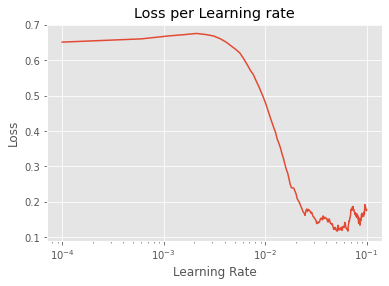

In [8]:
t = pt.Trainer(m, device, train_dl, val_dl)
r = t.find_lr(1e-4, 1e-1, 200)
pl.TrainPlot().plot_lr(r)

### Start Training and plot the results
> We train for __10 epochs__ and __learning rate 5e-3__. That means we run over the total training data set a total of 10 times/epochs where the model learns, after each epoch we use the trained model and perform a test run on the validation set.

Epoch 010/010: 100%|██████████| 3631/3631 [00:16<00:00, 214.92it/s, train_loss=0.0257, train_acc=0.992, val_loss=0.0172, val_acc=0.995]


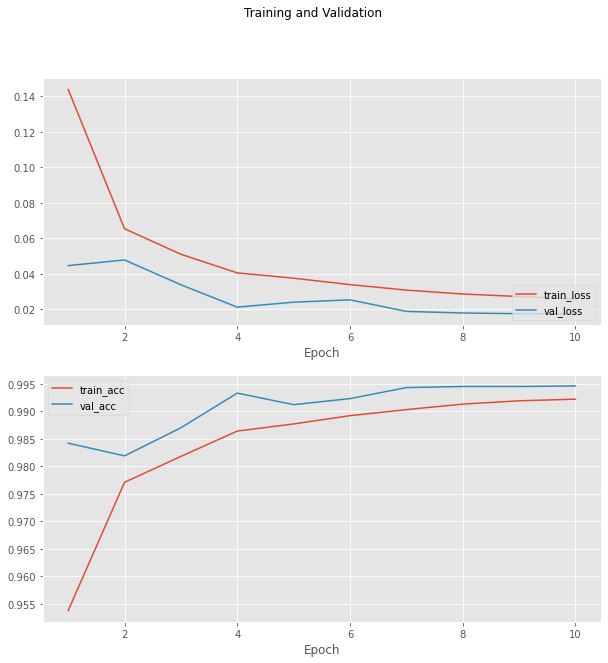

In [9]:
t = pt.Trainer(m, device, train_dl, val_dl)
h = t.train_one_cycle(10, 5e-3)
pl.TrainPlot().plot_history(h, fig_size=(10,10))

## Test the model on the test data

> Test the model on the test set, it is data that was not seen during training and allows us to validate model results.

Testing in 782 steps: 100%|██████████| 782/782 [00:01<00:00, 469.46it/s]


------------- Classification report -----------------
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     98926
         1.0       0.68      0.97      0.80      1074

    accuracy                           0.99    100000
   macro avg       0.84      0.98      0.90    100000
weighted avg       1.00      0.99      1.00    100000


auc score : 0.9993
ap score  : 0.9667
-----------------------------------------------------


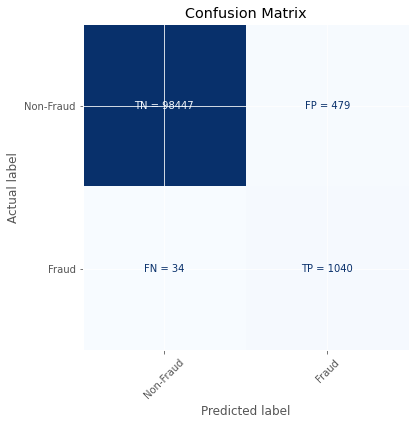

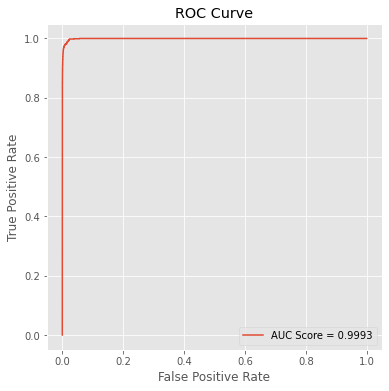

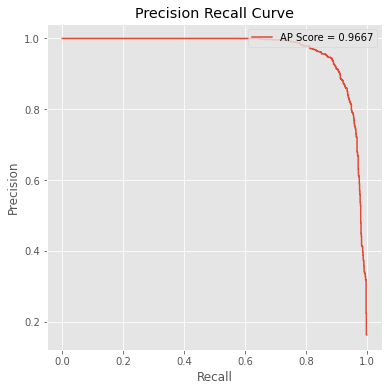

In [10]:
test_ds = pt.NumpyListDataSetMulti(multi_head_td, test_data)
test_dl = test_ds.data_loader(cpu, 128, num_workers=2)

ts = pt.Tester(m, device, test_dl)
pr = ts.test_plot()
tp = pl.TestPlot()
tp.print_classification_report(pr)
tp.plot_confusion_matrix(pr, fig_size=(6,6))
tp.plot_roc_curve(pr, fig_size=(6,6))
tp.plot_precision_recall_curve(pr, fig_size=(6,6))

## Plot Embeddings
> As we have embeddings in this model, we can visualize them.

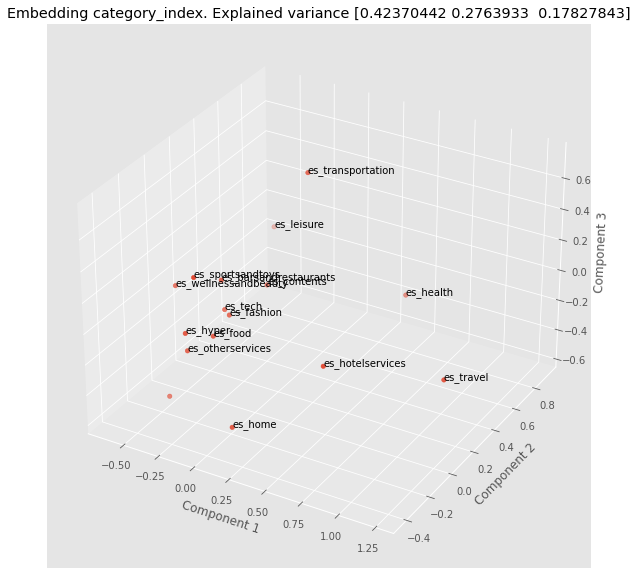

In [11]:
w = m.embedding_weights(category_i, True)
pl.LayerPlot().plot_embedding(category_i, w, dims=3, fig_size=(10,10))

# Conclusion
Our very rudimentary custom attention mechanism seems to have had a slight beneficial impact on the AUC-score of the model, but it did worse in terms of F1. It has considerably more parameters than the previous examples, so this might not be a fair comparison.

We need to be careful drawing conclusions due to the data and the fact the series are short. Attention was desinged to help models with long series. The real proof would be to increase the series to 50 or more and then compare results, ideally on very realistic data. Normally we'd expect to see bigger differences as the length of the series increases.